<a href="https://colab.research.google.com/github/Ndokania29/-backend/blob/main/SHL_Grammar_Scoring.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:

!pip install numpy==1.26.4


In [2]:

!pip install transformers==4.38.2


In [3]:
#!pip uninstall -y sentence-transformers
!pip install sentence-transformers==2.6.1


In [4]:
#!pip uninstall -y torch torchvision torchaudio
!pip install torch==2.2.2+cu118 torchvision==0.17.2+cu118 torchaudio==2.2.2+cu118 --index-url https://download.pytorch.org/whl/cu118


Looking in indexes: https://download.pytorch.org/whl/cu118


In [5]:
!pip install -U openai-whisper
!pip install -q sentence-transformers
!pip install -q language-tool-python
!pip install -q xgboost
!pip install -q librosa soundfile
!pip install -q spacy
!python -m spacy download en_core_web_sm


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 111.0 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


In [6]:
!pip uninstall -y pandas
!pip install pandas==2.1.4


Found existing installation: pandas 2.1.4
Uninstalling pandas-2.1.4:
  Successfully uninstalled pandas-2.1.4
  Using cached pandas-2.1.4-cp312-cp312-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (18 kB)
Using cached pandas-2.1.4-cp312-cp312-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (11.7 MB)
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires pandas==2.2.2, but you have pandas 2.1.4 which is incompatible.
plotnine 0.14.5 requires pandas>=2.2.0, but you have pandas 2.1.4 which is incompatible.
shap 0.50.0 requires numpy>=2, but you have numpy 1.26.4 which is incompatible.
xarray 2025.12.0 requires pandas>=2.2, but you have pandas 2.1.4 which is incompatible.
mizani 0.13.5 requires pandas>=2.2.0, but you have pandas 2.1.4 which is incompatible.


In [7]:
import os
import numpy as np
import pandas as pd
import librosa
import soundfile as sf

import whisper
from sentence_transformers import SentenceTransformer
import language_tool_python
import spacy

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error
from xgboost import XGBRegressor


In [8]:
import os

BASE_DIR = "/content/drive/MyDrive/SHL_Assignment"

TRAIN_AUDIO_DIR = os.path.join(BASE_DIR, "train_audio")
TEST_AUDIO_DIR  = os.path.join(BASE_DIR, "test_audio")

TRAIN_CSV = os.path.join(BASE_DIR, "train.csv")
TEST_CSV  = os.path.join(BASE_DIR, "test.csv")

print(os.listdir(BASE_DIR))


['SHL_Grammar_Scoring.ipynb', 'train.csv', 'test.csv', 'test_audio', 'train_audio', 'proc_train_audio', 'proc_test_audio', 'train_transcripts.csv']


In [9]:
import pandas as pd

train_df = pd.read_csv(TRAIN_CSV)
test_df  = pd.read_csv(TEST_CSV)

train_df.head(), test_df.head()


(    filename  label
 0  audio_173    3.0
 1  audio_138    3.0
 2  audio_127    2.0
 3   audio_95    2.0
 4   audio_73    3.5,
     filename
 0  audio_141
 1  audio_114
 2   audio_17
 3   audio_76
 4  audio_156)

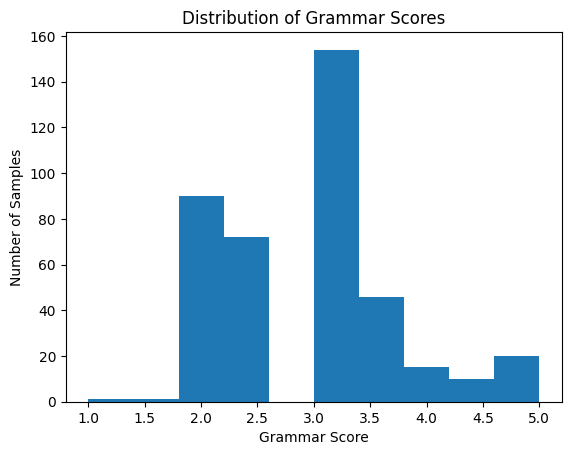

In [39]:
import matplotlib.pyplot as plt

plt.figure()
plt.hist(train_df["label"], bins=10)
plt.xlabel("Grammar Score")
plt.ylabel("Number of Samples")
plt.title("Distribution of Grammar Scores")
plt.show()


In [10]:
train_df["filename"] = train_df["filename"].astype(str) + ".wav"
test_df["filename"]  = test_df["filename"].astype(str) + ".wav"


In [11]:
import librosa
import soundfile as sf

PROC_TRAIN = os.path.join(BASE_DIR, "proc_train_audio")
PROC_TEST  = os.path.join(BASE_DIR, "proc_test_audio")

os.makedirs(PROC_TRAIN, exist_ok=True)
os.makedirs(PROC_TEST, exist_ok=True)

def preprocess_audio(src_dir, dst_dir, filenames):
    for f in filenames:
        in_path = os.path.join(src_dir, f)
        out_path = os.path.join(dst_dir, f)

        if not os.path.exists(out_path) and os.path.exists(in_path):
            audio, _ = librosa.load(in_path, sr=16000, mono=True)
            sf.write(out_path, audio, 16000)


In [12]:
preprocess_audio(TRAIN_AUDIO_DIR, PROC_TRAIN, train_df["filename"])
preprocess_audio(TEST_AUDIO_DIR,  PROC_TEST,  test_df["filename"])


In [13]:
"""
This cell standardizes audio files so that:
- all audios are mono
- all audios are 16kHz
- downstream models behave consistently

IMPORTANT:
This step is expensive, so we:
- skip files that are already processed
- process files in parallel
- never crash the pipeline if one file fails
"""

import librosa
import soundfile as sf
from concurrent.futures import ThreadPoolExecutor
from tqdm import tqdm

PROC_TRAIN = os.path.join(BASE_DIR, "proc_train_audio")
PROC_TEST  = os.path.join(BASE_DIR, "proc_test_audio")

os.makedirs(PROC_TRAIN, exist_ok=True)
os.makedirs(PROC_TEST, exist_ok=True)

def preprocess_single_audio(args):
    src_dir, dst_dir, fname = args
    src_path = os.path.join(src_dir, fname)
    dst_path = os.path.join(dst_dir, fname)

    # Skip if already processed
    if os.path.exists(dst_path):
        return

    try:
        audio, _ = librosa.load(src_path, sr=16000, mono=True)
        sf.write(dst_path, audio, 16000)
    except Exception as e:
        # We log and move on — production systems never die on single failures
        print(f"Failed processing {fname}: {e}")


In [14]:
def preprocess_dataset(audio_dir, output_dir, filenames):
    tasks = [(audio_dir, output_dir, f) for f in filenames]

    with ThreadPoolExecutor(max_workers=8) as executor:
        list(tqdm(
            executor.map(preprocess_single_audio, tasks),
            total=len(tasks),
            desc=f"Processing audio in {output_dir}"
        ))

preprocess_dataset(TRAIN_AUDIO_DIR, PROC_TRAIN, train_df["filename"])
preprocess_dataset(TEST_AUDIO_DIR,  PROC_TEST,  test_df["filename"])


Processing audio in /content/drive/MyDrive/SHL_Assignment/proc_train_audio: 100%|██████████| 409/409 [00:00<00:00, 9211.86it/s]
Processing audio in /content/drive/MyDrive/SHL_Assignment/proc_test_audio: 100%|██████████| 197/197 [00:00<00:00, 6996.31it/s]


In [15]:
import whisper

# Base model gives best speed vs accuracy tradeoff
whisper_model = whisper.load_model("base")


100%|████████████████████████████████████████| 139M/139M [00:00<00:00, 162MiB/s]


In [16]:
"""
This function:
- checks if transcript already exists
- only transcribes missing files
- saves progress after every run
"""

def transcribe_dataset(df, audio_dir, cache_path):
    if os.path.exists(cache_path):
        df_cached = pd.read_csv(cache_path)
        done_files = set(df_cached["filename"])
        df = df[~df["filename"].isin(done_files)]
        cached = df_cached
    else:
        cached = pd.DataFrame()

    transcripts = []

    for fname in tqdm(df["filename"], desc="Transcribing audio"):
        try:
            text = whisper_model.transcribe(
                os.path.join(audio_dir, fname)
            )["text"]

            transcripts.append({
                "filename": fname,
                "transcript": text
            })
        except Exception as e:
            transcripts.append({
                "filename": fname,
                "transcript": ""
            })
            print(f"Failed transcription {fname}: {e}")

    new_df = pd.DataFrame(transcripts)
    final_df = pd.concat([cached, new_df], ignore_index=True)
    final_df.to_csv(cache_path, index=False)

    return final_df


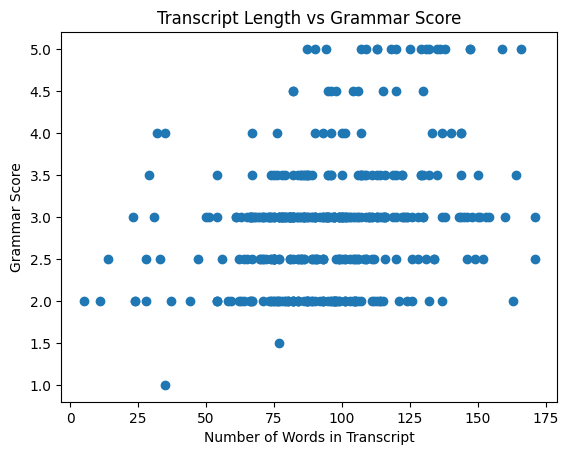

In [40]:
train_df["text_length"] = train_df["transcript"].apply(
    lambda x: len(x.split()) if isinstance(x, str) else 0
)

plt.figure()
plt.scatter(train_df["text_length"], train_df["label"])
plt.xlabel("Number of Words in Transcript")
plt.ylabel("Grammar Score")
plt.title("Transcript Length vs Grammar Score")
plt.show()


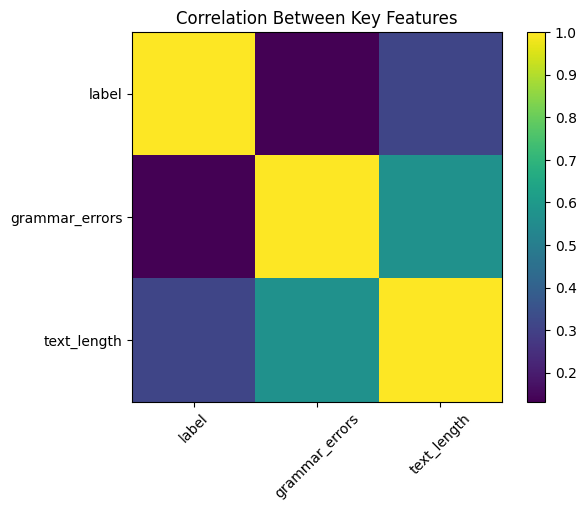

In [41]:
import pandas as pd

numeric_df = train_df[[
    "label",
    "grammar_errors",
    "text_length"
]]

corr = numeric_df.corr()

plt.figure()
plt.imshow(corr)
plt.colorbar()
plt.xticks(range(len(corr.columns)), corr.columns, rotation=45)
plt.yticks(range(len(corr.columns)), corr.columns)
plt.title("Correlation Between Key Features")
plt.show()


In [17]:
train_text = transcribe_dataset(
    train_df,
    PROC_TRAIN,
    os.path.join(BASE_DIR, "train_transcripts.csv")
)

train_df = train_df.merge(train_text, on="filename", how="left")


Transcribing audio: 0it [00:00, ?it/s]


In [18]:
test_text = transcribe_dataset(
    test_df,
    PROC_TEST,
    os.path.join(BASE_DIR, "test_transcripts.csv")
)

test_df = test_df.merge(test_text, on="filename", how="left")


Transcribing audio: 100%|██████████| 197/197 [07:31<00:00,  2.29s/it]


In [19]:
# Clean spoken text without fixing grammar
# This keeps mistakes but removes useless fillers

def clean_text(text):
    if not isinstance(text, str):
        return ""

    fillers = ["um", "uh", "ah", "hmm"]
    text = text.lower()

    for filler in fillers:
        text = text.replace(filler, "")

    return text.strip()

# Apply cleaning to both train and test
train_df["clean_text"] = train_df["transcript"].apply(clean_text)
test_df["clean_text"]  = test_df["transcript"].apply(clean_text)


In [20]:
from sentence_transformers import SentenceTransformer

# Lightweight, fast, production-safe model
embedder = SentenceTransformer("all-MiniLM-L6-v2")

# Convert cleaned text into numerical vectors
X_train_text = embedder.encode(
    train_df["clean_text"].tolist(),
    show_progress_bar=True
)

X_test_text = embedder.encode(
    test_df["clean_text"].tolist(),
    show_progress_bar=True
)


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

/usr/local/lib/python3.12/dist-packages/huggingface_hub/file_download.py:942: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

/usr/local/lib/python3.12/dist-packages/huggingface_hub/file_download.py:942: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

In [21]:
import language_tool_python

tool = language_tool_python.LanguageTool("en-US")

def count_grammar_errors(text):
    try:
        return len(tool.check(text))
    except:
        # In production, never crash because of one bad input
        return 0

train_df["grammar_errors"] = train_df["clean_text"].apply(count_grammar_errors)
test_df["grammar_errors"]  = test_df["clean_text"].apply(count_grammar_errors)


In [24]:
print(train_df.columns)


Index(['filename', 'label', 'transcript', 'clean_text', 'grammar_errors'], dtype='object')


In [25]:
import numpy as np

# Training features
X_train = np.hstack([
    X_train_text,
    train_df[["grammar_errors"]].values
])

# Test features (same pipeline, no changes)
X_test = np.hstack([
    X_test_text,
    test_df[["grammar_errors"]].values
])

# Target values (ONLY from train data)
y = train_df["label"].values


In [26]:
from sklearn.model_selection import train_test_split

X_tr, X_val, y_tr, y_val = train_test_split(
    X_train,
    y,
    test_size=0.2,
    random_state=42
)


In [27]:
print(train_df[["label"]].describe())


            label
count  409.000000
mean     2.910758
std      0.766953
min      1.000000
25%      2.500000
50%      3.000000
75%      3.000000
max      5.000000


In [28]:
from xgboost import XGBRegressor

model = XGBRegressor(
    n_estimators=300,
    learning_rate=0.05,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42
)

# Train ONLY on training split
model.fit(X_tr, y_tr)


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.8, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.05, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=6,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=300,
             n_jobs=None, num_parallel_tree=None, ...)

In [29]:
from sklearn.metrics import mean_squared_error
from scipy.stats import pearsonr

# Validation predictions
y_val_pred = model.predict(X_val)

# Clamp to valid grammar range
y_val_pred = np.clip(y_val_pred, 1.0, 5.0)

rmse = np.sqrt(mean_squared_error(y_val, y_val_pred))
pearson = pearsonr(y_val, y_val_pred)[0]

print("Validation RMSE:", rmse)
print("Validation Pearson:", pearson)


Validation RMSE: 0.7317157784582052
Validation Pearson: 0.2714869904391334


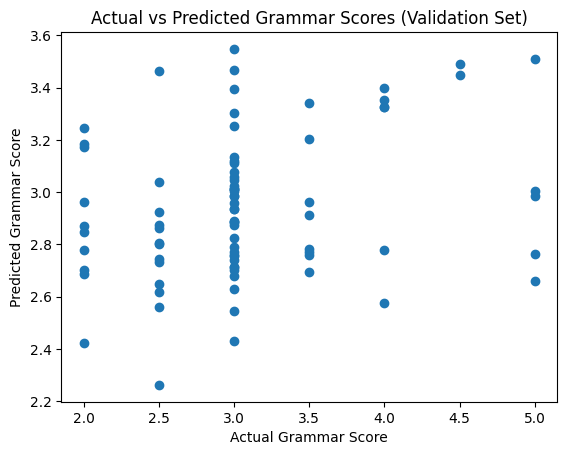

In [35]:
import matplotlib.pyplot as plt

plt.figure()
plt.scatter(y_val, y_val_pred)
plt.xlabel("Actual Grammar Score")
plt.ylabel("Predicted Grammar Score")
plt.title("Actual vs Predicted Grammar Scores (Validation Set)")
plt.show()


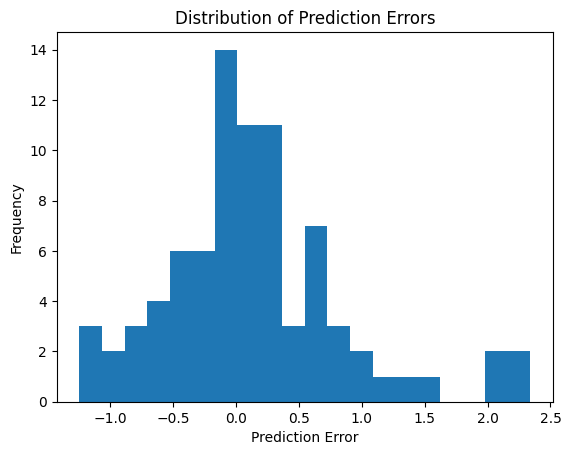

In [36]:
errors = y_val - y_val_pred

plt.figure()
plt.hist(errors, bins=20)
plt.xlabel("Prediction Error")
plt.ylabel("Frequency")
plt.title("Distribution of Prediction Errors")
plt.show()


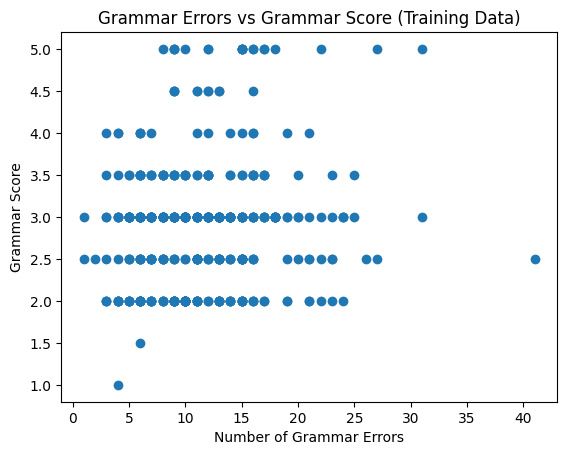

In [37]:
plt.figure()
plt.scatter(train_df["grammar_errors"], train_df["label"])
plt.xlabel("Number of Grammar Errors")
plt.ylabel("Grammar Score")
plt.title("Grammar Errors vs Grammar Score (Training Data)")
plt.show()


In [30]:
# Train model on full training data
model.fit(X_train, y)


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.8, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.05, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=6,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=300,
             n_jobs=None, num_parallel_tree=None, ...)

In [31]:
test_predictions = model.predict(X_test)
test_predictions = np.clip(test_predictions, 1.0, 5.0)


In [32]:
import os
import pandas as pd

submission = pd.DataFrame({
    "filename": test_df["filename"].str.replace(".wav", "", regex=False),
    "grammar_score": test_predictions
})

submission_path = os.path.join(BASE_DIR, "submission.csv")
submission.to_csv(submission_path, index=False)

submission.head()


,filename,grammar_score
0,audio_141,2.764978
1,audio_114,3.150382
2,audio_17,3.205973
3,audio_76,3.606447
4,audio_156,2.638441


from matplotlib import pyplot as plt
_df_0['grammar_score'].plot(kind='hist', bins=20, title='grammar_score')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
_df_1.groupby('filename').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_2['grammar_score'].plot(kind='line', figsize=(8, 4), title='grammar_score')
plt.gca().spines[['top', 'right']].set_visible(False)

<string>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.



from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(_df_3['filename'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(_df_3, x='grammar_score', y='filename', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

In [33]:
import joblib

joblib.dump(model, os.path.join(BASE_DIR, "grammar_xgb_model.pkl"))
joblib.dump(embedder, os.path.join(BASE_DIR, "text_embedder.pkl"))


['/content/drive/MyDrive/SHL_Assignment/text_embedder.pkl']

In [34]:
print(submission.shape)          # should match test set size
print(submission.isnull().sum()) # should be zero
print(submission.describe())


(197, 2)
filename         0
grammar_score    0
dtype: int64
       grammar_score
count     197.000000
mean        3.012502
std         0.328739
min         2.374002
25%         2.786285
50%         2.966841
75%         3.156795
max         4.420633
